In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
import datetime
import random
from datetime import date
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import statistics 
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeClassifier, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
def convert_strings_to_dates(dataframe, testset=False):
    frame = dataframe.copy()
    if testset:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    else:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.most_recent_load_date = [date.fromisoformat(d) for d in frame.most_recent_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    return frame

In [3]:
def convert_date_to_int(dataframe, columns):
    frame = dataframe.copy()
    conversion = lambda dt_time: 10000*dt_time.year + 100*dt_time.month + dt_time.day
    
    for col in columns:
        frame[f'{col}'] = [conversion(d) for d in frame[f'{col}']]

    return frame

In [4]:
def aggregate_rows_by_driver_id(dataframe):
    '''
    Returns a new dataframe indexed by Driver ID using an optimal set of aggregations per column.
    This method will return a dataframe that only contains the columns listed below.
    Note: duplicate columns are inherently pruned (simply by not adding them below), so it is 
        safe to pass in the full dataframe and expect a pruned version in return. 
        Also note that the `id_driver` will now be the index of the dataframe and NOT its own column.
    '''
    minimum = 'min'
    maximum = 'max'
    median = 'median'
    random_mode = lambda x: random.choice(pd.Series.mode(x if isinstance(x, list) else list(x)))
    average = lambda x: pd.Series.mean(x)

    aggregation = {
        'dt': maximum,
        'weekday': random_mode,
        'dim_carrier_type': random_mode,
        'carrier_trucks': mode,
        'num_trucks': maximum,
        'interested_in_drayage': random_mode,
        'port_qualified': random_mode,
        'signup_source': random_mode,
        'ts_signup': maximum,
        'days_signup_to_approval': maximum,
        'driver_with_twic': mode,
        'dim_preferred_lanes': mode,
        'first_load_date': minimum,
        'loads': random_mode,
        'marketplace_loads_otr': maximum,
        'marketplace_loads_atlas': maximum,
        'marketplace_loads': maximum,
        'brokerage_loads_otr': maximum,
        'brokerage_loads_atlas': maximum,
        'brokerage_loads': maximum,
        'label': random_mode
    }

    return dataframe.groupby(['id_driver']).agg(aggregation)

In [5]:
def augment_boolean_columns(dataframe):
    frame = dataframe.copy()
    label_encoder = LabelEncoder()
    
    # Replacement (no new columns needed, just transform strings to 0 or 1)
    frame['interested_in_drayage'] = label_encoder.fit_transform(frame.interested_in_drayage)
    frame['port_qualified'] = label_encoder.fit_transform(frame.port_qualified)
    frame['driver_with_twic'] = label_encoder.fit_transform(frame.driver_with_twic)
    
    # Create new columns with more appropriate names, delete the old columns
    frame['self_owned'] = label_encoder.fit_transform(frame.dim_carrier_type)
    frame['mobile_signup'] = np.logical_xor(label_encoder.fit_transform(frame.signup_source), 1).astype(int)
    frame['has_route_preference'] = label_encoder.fit_transform(~frame.dim_preferred_lanes.isnull())
    frame.drop(columns=['dim_carrier_type', 'signup_source', 'dim_preferred_lanes'], inplace=True)
    
    return frame

In [6]:
def encode_categorical_columns(dataframe):
    frame = dataframe.copy()

    # Encode various truck types
    trucks = pd.get_dummies(frame.carrier_trucks)
    trucks.columns = ['truck-' + c.replace('[', '').replace(']', '').replace('"', '').replace(',', '').replace(' ', '-') for c in trucks.columns]
    
    # Encode the 7 different days of the week
    weekdays = pd.get_dummies(frame.weekday)
    weekdays.columns = [f'prefers-{x}'.lower() for x in weekdays.columns]
    
    # Drop the originals since they are no longer needed.
    frame.drop(columns=['carrier_trucks', 'weekday'], inplace=True)
    
    # Concatenate various new frames with the original and return
    result = pd.concat([frame, trucks, weekdays], axis=1)
    return result

In [7]:
def standardize_numericals(dataframe, columns=None):    
    scaler = StandardScaler()
    frame = None
    
    if columns:
        frame = dataframe[columns].copy()
    else:
        frame = dataframe.copy()
    
    x = scaler.fit_transform(frame)
    scaled_df = pd.DataFrame(x)
    scaled_df.columns = frame.columns

    
    if columns:
        frame = dataframe.copy()
        frame[columns] = scaled_df.values
    else:
        frame = scaled_df.copy()
    
    return frame

In [8]:
def impute_numericals(dataframe, columns, strategy='most_frequent', testset=False):
    frame = dataframe.copy()
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    
    for col in columns:
        imp.fit(frame[f'{col}'].values.reshape(-1, 1))
        frame[f'{col}'] = imp.transform(frame[f'{col}'].values.reshape(-1, 1))
    
    return frame

In [9]:
def generate_labels(dataframe, loads_percentile, most_recent_percentile):
    label_encoder = LabelEncoder()
    frame = dataframe.copy()
    
    labels = (frame.total_loads > loads_percentile) & (frame.most_recent_load_date > most_recent_percentile)
    frame['label'] = label_encoder.fit_transform(labels)
    frame.drop(columns=['total_loads', 'most_recent_load_date'], inplace=True)
    
    return frame

In [10]:
def get_Xy(dataframe, aggregate=False, standardize=False, testdata=False):
    frame = dataframe.copy()
    scaler = StandardScaler()
    if not testdata:
        loads_75th_percentile = dataframe["total_loads"].quantile(0.75)
    most_recent_75th_percentile = date(year=2021, month=2, day=10)


    if testdata:
        frame = convert_strings_to_dates(frame, testset=True)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        # The only columns not in the new frame should be booleans that are safely set to 0
        for col in dataframe.columns:
            if col not in frame.columns:
                frame[f'{col}'] = 0

        frame.drop(columns=['weekday'], inplace=True)
        frame = impute_numericals(frame, ['days_signup_to_approval'])

        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        return frame, None
    
    
    frame = convert_strings_to_dates(frame)
    
    if aggregate:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = aggregate_rows_by_driver_id(frame)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels
    else:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels

## Load CSV to DataFrame

In [11]:
train_df = pd.read_csv('training_dataset_V3.csv')
test_df = pd.read_csv('score_V3.csv')

**Drops duplicates and unwanted columns**

In [12]:
train_Ids = train_df['Unnamed: 0']
train_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)
train_df.dropna(subset=['days_signup_to_approval', 'num_trucks'], inplace=True)

test_Ids = test_df['Unnamed: 0']
test_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)

---

# 1 - Generate Labels and 4 - Pipeline

In [13]:
# Use this when you want to generate output for Kaggle
X_train, y_train = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
X_test, _ = get_Xy(test_df, standardize=True, aggregate=False, testdata=True)

In [14]:
# testing the number of labels
np.sum(np.array(y_train)) / len(y_train)

0.1519867176947321

In [15]:
# Use this for training/testing your model
X, y = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
X_train.shape, y_train.shape

((56857, 40), (56857,))

In [17]:
X_test.shape, y_test.shape

((14215, 40), (14215,))

# 5 - Linear Regression

## Perform a logistic regression on all the variables

MSE of test data = 0.078016
MSE of train data = 0.074608
R^2 of Test = 0.92198
R^2 of Train = 0.92539


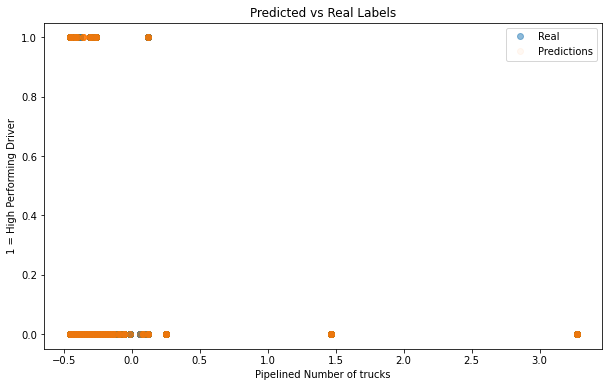

In [18]:
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# report scores 
r2_test = clf.score(X_test, y_test)
r2_train = clf.score(X_train, y_train)
mse_test = mean_squared_error(pred, y_test)
mse_train = mean_squared_error(y_train, clf.predict(X_train))

print(f'MSE of test data = {mse_test:.5}')
print(f'MSE of train data = {mse_train:.5}')
print(f'R^2 of Test = {r2_test:.5}')
print(f'R^2 of Train = {r2_train:.5}')

# plotting the y versus the predicted y
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(X_test.num_trucks, y_test, 'o', label="Real", alpha=0.5)
ax.plot(X_test.num_trucks, pred, 'o', label="Predictions", alpha=0.05)
ax.set_xlabel("Pipelined Number of trucks")
ax.set_ylabel("1 = High Performing Driver")
ax.set_title("Predicted vs Real Labels")
ax.legend()

## Perform a bootstrap with 150 samples to get a distribution of predictor coefficients

In [19]:
n_estimators = 100
sample_size = 3148
model = BaggingRegressor(LogisticRegression(max_iter=200), 
                         n_estimators=n_estimators,
                         bootstrap=True, max_samples=sample_size)

model.fit(X_train, y_train)

BaggingRegressor(base_estimator=LogisticRegression(max_iter=200),
                 max_samples=3148, n_estimators=100)

In [20]:
tot_columns = len(X_train.columns)
intercept=[]
beta=[ [] for _ in range(tot_columns)]

for m in model.estimators_:
    intercept.append(m.intercept_)
    for i in range(tot_columns):
        beta[i].append(m.coef_[0][i])

coef_mean = []
coef_std = []

print(f'Intercept mean: {np.mean(intercept):<25.2f}std: {np.std(intercept):.2f}')
for i, b in enumerate(beta):
    print(f'Predictor {i} mean: {np.mean(beta[i]):<25.2f}std: {np.std(beta[i]):.2f}')
    coef_mean.append(np.mean(beta[i]))
    coef_std.append(np.std(beta[i]))

Intercept mean: -5.43                    std: 0.18
Predictor 0 mean: 1.64                     std: 0.12
Predictor 1 mean: 0.27                     std: 0.07
Predictor 2 mean: 1.60                     std: 0.12
Predictor 3 mean: -0.00                    std: 0.16
Predictor 4 mean: 0.16                     std: 0.11
Predictor 5 mean: 1.13                     std: 0.14
Predictor 6 mean: 0.27                     std: 0.17
Predictor 7 mean: -0.61                    std: 0.03
Predictor 8 mean: 0.27                     std: 0.24
Predictor 9 mean: -0.02                    std: 0.11
Predictor 10 mean: -0.24                    std: 0.08
Predictor 11 mean: 0.80                     std: 0.06
Predictor 12 mean: 0.84                     std: 0.07
Predictor 13 mean: 0.07                     std: 0.08
Predictor 14 mean: -0.16                    std: 0.07
Predictor 15 mean: -4.87                    std: 0.36
Predictor 16 mean: -0.40                    std: 0.18
Predictor 17 mean: -0.03                 

## Perform a t-test on all the predictors, and use p-values to determine which predictors are most significant. Perform a VIF test on to see which predictors are highly correlated

In [21]:
t_statistic = []
p_val = []
for i in range(tot_columns):
    stats = st.ttest_1samp(beta[i], 0)
    t_statistic.append(stats.statistic)
    p_val.append(stats.pvalue/2)

discard = {}
for i,p in enumerate(p_val):
    if p > 0.05:
        discard[i] = p
discard

{3: 0.421202925756515,
 20: 0.29369704933130736,
 23: 0.25216255422558803,
 29: 0.13270295638269491,
 37: 0.35676712863764704}

In [22]:
X_sig_pred = X.copy()
X_sig_pred.drop(X_sig_pred.columns[list(discard.keys())],axis=1, inplace=True)
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_sig_pred.columns 
vif_data["VIF"] = [variance_inflation_factor(X_sig_pred.values, i) for i in range(len(X_sig_pred.columns))]  
print('\n', vif_data, '\n')

vif_data.replace(np.inf, np.nan, inplace=True) 
vif_data.dropna(inplace=True) 
vif_data

keep_columns = list(vif_data.feature)
X_sig_pred = X_sig_pred[keep_columns]
X_sig_pred.info()

C:\Users\myLaptop\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)



                             feature           VIF
0                   brokerage_loads           inf
1             brokerage_loads_atlas           inf
2               brokerage_loads_otr           inf
3                  driver_with_twic  4.351993e+00
4                                dt  3.050112e+00
5                   first_load_date  9.184203e+00
6              has_route_preference  1.074831e+00
7                         id_driver  1.016668e+01
8             interested_in_drayage  2.014082e+00
9                             loads  1.415320e+00
10                marketplace_loads  4.784352e+07
11          marketplace_loads_atlas  6.450426e+07
12            marketplace_loads_otr  6.193921e+11
13                    mobile_signup  1.460149e+00
14                       num_trucks  3.865098e+00
15                   port_qualified  6.104266e+00
16                   prefers-friday  1.480515e+00
17                   prefers-monday  1.403242e+00
18                 prefers-saturday  1.285238e+0

## Select significant predictors based on results and build another linear regression model

In [23]:
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(X_sig_pred, y, test_size=0.20, random_state=42)

MSE of test data = 0.10798
MSE of train data = 0.10985
R^2 of Test = 0.89202
R^2 of Train = 0.89015

                            Feature  Coefficient
0                         Intercept    -4.349690
1                  driver_with_twic    -0.150627
2                                dt     1.088362
3                   first_load_date    -0.229214
4              has_route_preference    -1.284125
5                         id_driver    -0.552902
6             interested_in_drayage     0.160826
7                             loads     0.361578
8                 marketplace_loads     0.655462
9           marketplace_loads_atlas     0.703758
10            marketplace_loads_otr     0.032786
11                    mobile_signup     0.002639
12                       num_trucks    -2.935999
13                   port_qualified    -0.380272
14                   prefers-friday    -0.033735
15                   prefers-monday     0.019253
16                 prefers-saturday     0.028795
17               

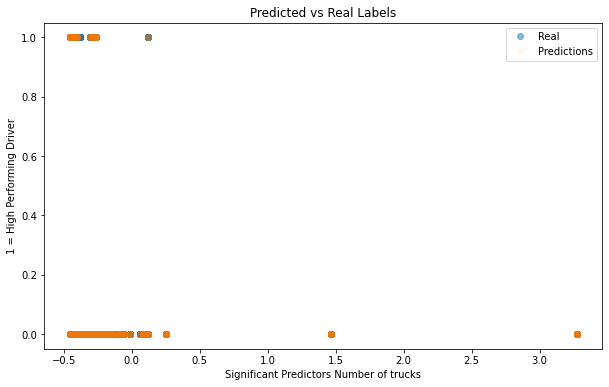

In [24]:
# train logistic model
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_sig, y_train_sig)
pred = clf.predict(X_test_sig)

# report scores 
r2_test = clf.score(X_test_sig, y_test_sig)
r2_train = clf.score(X_train_sig, y_train_sig)
mse_test = mean_squared_error(pred, y_test_sig)
mse_train = mean_squared_error(y_train_sig, clf.predict(X_train_sig))

print(f'MSE of test data = {mse_test:.5}')
print(f'MSE of train data = {mse_train:.5}')
print(f'R^2 of Test = {r2_test:.5}')
print(f'R^2 of Train = {r2_train:.5}\n')

# coeffcients
new_row = pd.DataFrame({'Feature':'Intercept', 'Coefficient': clf.intercept_}, index=[0]) 
predictors = pd.DataFrame() 
predictors["Feature"] = X_sig_pred.columns
predictors["Coefficient"] = clf.coef_[0]
predictors = pd.concat([new_row, predictors]).reset_index(drop = True)
print(predictors)

# plotting the y versus the predicted y
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(X_test_sig.num_trucks, y_test_sig, 'o', label="Real", alpha=0.5)
ax.plot(X_test_sig.num_trucks, pred, 'o', label="Predictions", alpha=0.05)
ax.set_xlabel("Significant Predictors Number of trucks")
ax.set_ylabel("1 = High Performing Driver")
ax.set_title("Predicted vs Real Labels")
ax.legend()

# 6 - PCA

# 7 - Ensemble Method

# 8 - Neural Network

# 9 - Cross Validation

# 10 - Custom Model

In [25]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

1.0